# TL;DR

My attempt at the Spooky Author Identification task. This kernel focuses on  grammatical feature extraction, plus some innovative data exploration/visualization and a dab of neural network classification.

# Loading data & libraries

External libraries plus some of my own. You'll need to get the .py lib files from [here](https://github.com/happythenewsad/cis545project) if you want to run this kernel. [This writeup](https://github.com/happythenewsad/cis545project/blob/master/docs/writeup.pdf) explains this kernel in more detail as well.

In [4]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import sys
import math
import os
import time
import numpy as np
import nltk
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
nltk.download('stopwords')

# local code
sys.path.insert(1, "./code/")
from Utils import Utils # my library
from Eval import Eval # my library
from Extract import Extract # my library


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [ ]:
Utils.check_for_nulls(train_df)

I used manual train/val/test partitioning. 

In [7]:
if os.path.isfile('data/traindata.pickle'):
    traindata = pd.read_pickle('data/traindata.pickle')
    valdata   = pd.read_pickle('data/valdata.pickle')
    testdata  = pd.read_pickle('data/testdata.pickle')
else: 
    VAL_IDX  = math.ceil(len(train_df) * .8)
    TEST_IDX = math.ceil(len(train_df) * .9)

    traindata = train_df[:VAL_IDX]
    valdata   = train_df[VAL_IDX:TEST_IDX]
    testdata  = train_df[TEST_IDX:]

    print(VAL_IDX, TEST_IDX)

    traindata.to_pickle('data/traindata.pickle')
    valdata.to_pickle('data/valdata.pickle')
    testdata.to_pickle('data/testdata.pickle')

In [8]:
print("traindata: {}, valdata: {}, testdata: {}".format(len(traindata), len(valdata), len(testdata)))

traindata: 15664, valdata: 1958, testdata: 1957


In [2]:
def logtime():
    timenow = time.asctime( time.localtime(time.time()) )
    print("Finished at: ", timenow)

# Feature engineering

In [10]:
# labels
Y_train = list(traindata.author )
Y_val = list(valdata.author)
Y_test = list(testdata.author)

Grammatical feature engineering. We want to include stopwords here. 
The crude form of data memoization below is helpful for speeding up
feature extraction.

In [11]:
def gen_gram_feats(name, seq_no, train, val, test):
    train_df = Extract.gram_feats(train.text, None, seq_no)

    gram_feat_list = list(train_df.columns)

    val_df = Extract.gram_feats(val.text, gram_feat_list, seq_no)
    test_df = Extract.gram_feats(test.text, gram_feat_list, seq_no)

    # removes a singleton feature
    for df in [train_df, val_df, test_df]:
        if 'SYM_count' in list(df.columns):
            df.drop('SYM_count', axis=1, inplace=True)
        
    train_df.to_pickle('data/train_' + name + '_df.pickle')
    val_df.to_pickle('data/val_' + name + '_df.pickle')
    test_df.to_pickle('data/test_' + name + '_df.pickle')       


if os.path.isfile('data/train_gram_df.pickle'):
    print("reading gram feats from pickle")
else:
    print("writing gram feats pickles")
    gen_gram_feats('gram', None, traindata, valdata, testdata)
    gen_gram_feats('gram_seq', 7, traindata, valdata, testdata)
    
train_gram_df = pd.read_pickle('data/train_gram_df.pickle')
val_gram_df   = pd.read_pickle('data/val_gram_df.pickle')
test_gram_df  = pd.read_pickle('data/test_gram_df.pickle')

train_gram_seq_df = pd.read_pickle('data/train_gram_seq_df.pickle')
val_gram_seq_df   = pd.read_pickle('data/val_gram_seq_df.pickle')
test_gram_seq_df  = pd.read_pickle('data/test_gram_seq_df.pickle')
    
logtime()

reading gram feats from pickle
Finished at:  Mon Dec 10 19:47:17 2018


Let's check that our data dimensions are sane. 

In [12]:
print(train_gram_df.shape)
print(val_gram_df.shape)
print(test_gram_df.shape)

print(train_gram_seq_df.shape)
print(val_gram_seq_df.shape)
print(test_gram_seq_df.shape)

assert(train_gram_df.shape == (15664, 23))
assert(train_gram_seq_df.shape == (15664, 1622))


(15664, 23)
(1958, 23)
(1957, 23)
(15664, 1622)
(1958, 1622)
(1957, 1622)


In [13]:
train_gram_seq_df.head()

,,ADJ_count,ADP_count,ADV_count,CCONJ,CCONJ_CCONJ_CCONJ_VERB_NOUN,CCONJ_CCONJ_NOUN,CCONJ_CCONJ_NOUN_CCONJ_NOUN_CCONJ_NOUN,CCONJ_CCONJ_NOUN_CCONJ_NOUN_NOUN_VERB,CCONJ_CCONJ_NOUN_CCONJ_NOUN_VERB_VERB,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
0,0.0,0.235080,0.513819,0.627603,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.363031,0.277382,0.0,-0.1611,-0.018801,0.0,-0.237475,2.918125,0.762854
1,0.0,-0.737871,-0.660999,0.084256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.191755,-0.288286,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,-0.726940
2,0.0,1.208031,0.513819,-0.459090,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.199733,0.923860,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,0.474207
3,0.0,0.883714,0.513819,0.084256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.493349,0.439002,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,0.530074
4,0.0,0.235080,-0.367294,1.170950,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.150797,-0.409501,0.0,-0.1611,-0.018801,0.0,-0.237475,1.238739,0.232115


## Textual feature engineering

In [51]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=1500)

train_text_feats = vectorizer.fit_transform(traindata.text)
val_text_feats = vectorizer.transform(valdata.text) 
test_text_feats = vectorizer.transform(testdata.text) 

cols = ["text_" + str(x) for x in range(train_text_feats.shape[1])]

train_text_feats_df = pd.DataFrame(train_text_feats.todense(), index=None, columns=cols)
val_text_feats_df = pd.DataFrame(val_text_feats.todense(), index=None, columns=cols)
test_text_feats_df = pd.DataFrame(test_text_feats.todense(), index=None, columns=cols)

print(train_text_feats_df.shape)
print(val_text_feats_df.shape)
print(test_text_feats_df.shape)


(15664, 1500)
(1958, 1500)
(1957, 1500)


In [16]:
train_text_feats_df.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_90,text_91,text_92,text_93,text_94,text_95,text_96,text_97,text_98,text_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.458282,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.715019,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


## Let's make some features with Gensim

In [17]:
import numpy as np
import gensim
GENSIM = True

if GENSIM:
    logtime()
    #https://radimrehurek.com/gensim/models/doc2vec.html
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    #TaggedDocument does not filter or stem

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(traindata.text))]
    model = Doc2Vec(documents, vector_size=1500, window=2, min_count=1, workers=4)

    train_gensim = np.array([model.infer_vector(x) for x in list(traindata.text)])
    val_gensim = np.array([model.infer_vector(x) for x in list(valdata.text)])
    test_gensim = np.array([model.infer_vector(x) for x in list(testdata.text)])

    # numpy to pandas
    cols = ["gensim_" + str(x) for x in range(len(train_gensim[0]))]

    train_gensim_df = pd.DataFrame(train_gensim, index=None, columns=cols)
    val_gensim_df = pd.DataFrame(val_gensim, index=None, columns=cols)
    test_gensim_df = pd.DataFrame(test_gensim, index=None, columns=cols)
    logtime()
    
# gensim didn't help. so we're settling on tfidf extual features for now, and will explore neural models


Finished at:  Mon Dec 10 19:47:18 2018
Finished at:  Mon Dec 10 19:47:43 2018


# Exploration
Let's build author-specific lexicons and create some visualizations from them.

In [20]:
mws_df = train_df[train_df.author == 'MWS']
hpl_df = train_df[train_df.author == 'HPL']
eap_df = train_df[train_df.author == 'EAP']

cutoff = min([mws_df.shape[0], hpl_df.shape[0], eap_df.shape[0]])

# equalize corpus sizes to avoid bias during exploration
mws_df = mws_df[:cutoff]
hpl_df = hpl_df[:cutoff]
eap_df = eap_df[:cutoff]

mws_lexicon = Utils.build_lexicon(mws_df.text, STOPWORDS)
hpl_lexicon = Utils.build_lexicon(hpl_df.text, STOPWORDS)
eap_lexicon = Utils.build_lexicon(eap_df.text, STOPWORDS)

# sanity check
assert(cutoff * 3 == len(mws_df) + len(hpl_df) + len(eap_df))

# add grammatical features (for exploration this time, not training)
mws_gram_feats_df = Extract.gram_feats(mws_df.text, None, None)
hpl_gram_feats_df = Extract.gram_feats(hpl_df.text, None, None)
eap_gram_feats_df = Extract.gram_feats(eap_df.text, None, None)

mws_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,...,5.635000e+03,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5635.0,5635.0,5.635000e+03,5.635000e+03,5.635000e+03
mean,5.043782e-18,6.777582e-17,2.395796e-17,-7.187389e-17,9.457091e-18,2.521891e-18,4.980734e-17,1.670753e-17,1.891418e-18,4.224167e-17,...,7.880909e-20,1.387040e-17,4.539403e-17,0.0,-3.120840e-17,0.0,0.0,1.639229e-17,-7.565672e-18,-3.152364e-17
std,1.000000e+00,9.609892e-01,1.000000e+00,8.428109e-01,9.289644e-01,1.797328e-01,1.000000e+00,3.101639e-01,6.326520e-01,9.163641e-01,...,5.807221e-02,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.669821e-01,-8.362820e-01,-8.746468e-01,-6.749403e-01,-7.230532e-01,-2.697985e-01,-1.032234e+00,-3.935250e-01,-5.018364e-01,-6.978646e-01,...,-2.874173e-01,-1.238327e+00,-9.793490e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-1.017688e+00
25%,-6.949294e-01,-5.730821e-01,-8.746468e-01,-6.749403e-01,-3.758420e-01,0.000000e+00,-4.800391e-01,0.000000e+00,-5.018364e-01,-6.978646e-01,...,0.000000e+00,-4.909876e-01,-9.793490e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-5.281714e-01
50%,-1.508239e-01,-4.668209e-02,-3.236535e-01,0.000000e+00,-2.863082e-02,0.000000e+00,-1.119090e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.920516e-01,-1.519656e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-1.785166e-01
75%,3.932816e-01,2.165179e-01,2.273397e-01,9.130644e-02,3.185804e-01,0.000000e+00,2.562212e-01,0.000000e+00,0.000000e+00,1.000804e-01,...,0.000000e+00,2.563523e-01,4.685719e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,7.428701e-01,3.110000e-01
max,3.059114e+01,3.311652e+01,2.171608e+01,1.924748e+01,3.226201e+01,7.693608e+00,3.449232e+01,7.238050e+00,1.794448e+01,2.443740e+01,...,4.023842e+00,9.224431e+00,6.467101e+00,0.0,1.138564e+01,0.0,0.0,2.594267e+01,7.404349e+00,3.505114e+01


## Named Entity Exploration
NER wasn't that helpful for this task. Check the writeup for more details.

Many sentences don't have any entities, like this example:
'In whatever way the shifting is managed, it is of course concealed at every step from observation.'

In [22]:
NER = False
if NER:
    import spacy
    spacy_mdl = spacy.load('en_core_web_sm')

    def sent_to_ents(sent, spacy):
        sent = spacy(sent)
        ents = []
        for ent in sent.ents:
            ents.append(ent.text + ':' + ent.label_)
        return ents

    entities = []
    for i in range(1500):
        sent = valdata.iloc[i].text
        ents = sent_to_ents(sent, spacy_mdl)
        entities.append(ents)


In [23]:
if NER:
    import statistics as stat
    entity_freq = [len(x) for x in entities]

    print("stats for NER within a sample group: \n")
    print("min: {} \nmax: {} \nmean: {} \nstdev: {}" \
          .format(min(entity_freq), max(entity_freq), stat.mean(entity_freq), stat.stdev(entity_freq)))

# Exploration - visualization

In [24]:
def plot_word_freq(lexicon, name, quantity=20):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    elems = [x[0] for x in lexicon[:quantity]]
    y_pos = np.arange(quantity)
    vals = [x[1] for x in lexicon[:quantity]]

    ax.barh(y_pos, vals, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(elems)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Corpus-wide frequency')
    ax.set_title(name + ' - Word Frequencies')

    plt.show()
 
authors = {'MWS': mws_lexicon, 'HPL': hpl_lexicon, 'EAP': eap_lexicon}

pd.set_option('display.max_colwidth', -1)
print("Example MWS sentence: \n{}\n".format(mws_df.text[:1].to_string()))
print("Example HPL sentence: \n{}\n".format(hpl_df.text[:1].to_string()))
print("Example EAP sentence: \n{}\n".format(eap_df.text[:1].to_string()))
pd.set_option('display.max_colwidth', 80)


Example MWS sentence: 
3    How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

Example HPL sentence: 
1    It never once occurred to me that the fumbling might be a mere mistake.

Example EAP sentence: 
0    This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.



In [25]:
def plot_box(df, subset):
    features = {
        'tag_features': [
             'ADJ_count',
             'ADP_count',
             'ADV_count',
             'CCONJ_count',
             'DET_count',
             'NOUN_count',
             'PRON_count',
             'VERB_count'],
        'punc_features': [
            'bang_count',
            'colon_count',
            'ellipse_count',
            'lparen_count',
            'quote_count',
            'semicolon_count'],
        'ratio_features': [
             'adj_noun_ratio',
             'adv_verb_ratio',
             'sent_len']
    }
    
    fig, ax = plt.subplots()
    boxplot = df.boxplot(column=features[subset], \
        showfliers=False, fontsize=6, figsize=None)
    plt.show()

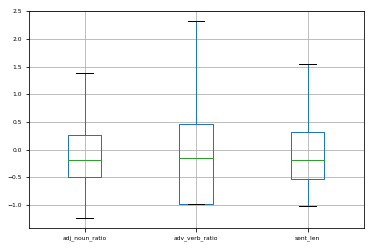

In [26]:
plot_box(mws_gram_feats_df, 'ratio_features')

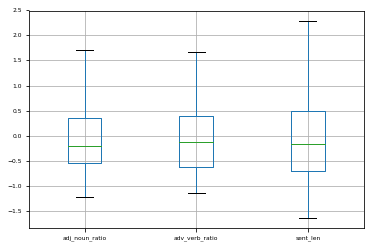

In [27]:
plot_box(hpl_gram_feats_df, 'ratio_features')

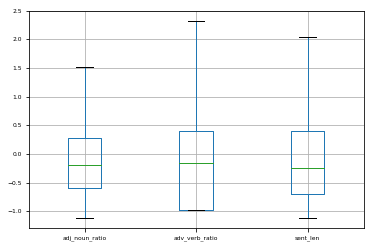

In [28]:
plot_box(eap_gram_feats_df, 'ratio_features')

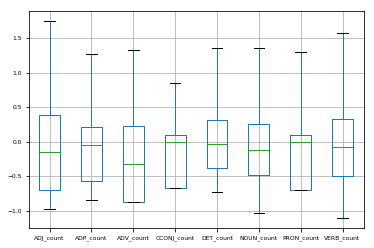

In [29]:
plot_box(mws_gram_feats_df, 'tag_features')

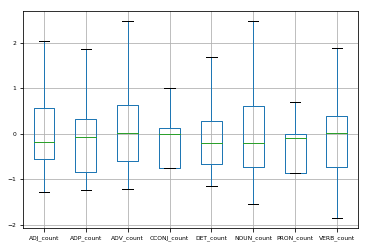

In [30]:
plot_box(hpl_gram_feats_df, 'tag_features')

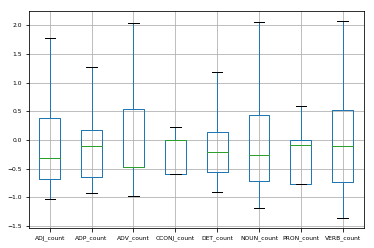

In [31]:
plot_box(eap_gram_feats_df, 'tag_features')

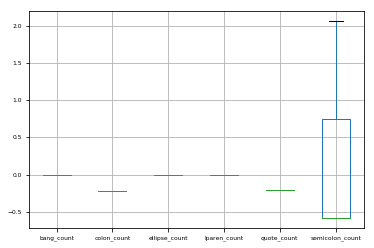

In [32]:
plot_box(mws_gram_feats_df, 'punc_features')

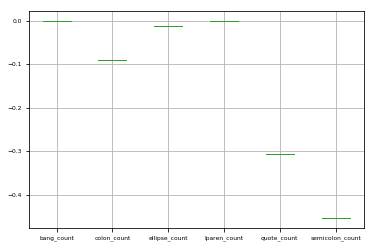

In [33]:
plot_box(hpl_gram_feats_df, 'punc_features')

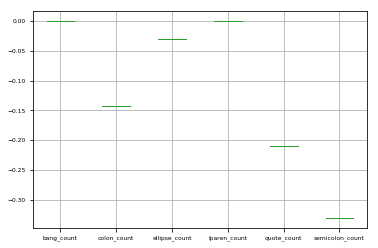

In [34]:
plot_box(eap_gram_feats_df, 'punc_features')

In [35]:
eap_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,...,5.635000e+03,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5.635000e+03,5.635000e+03
mean,-3.278458e-17,3.782836e-18,-3.908931e-17,4.413309e-17,9.330996e-17,-7.880909e-19,9.330996e-17,-1.008756e-17,-3.026269e-17,-1.052889e-16,...,1.418564e-18,1.525744e-16,1.008756e-17,0.0,1.040280e-17,-3.152364e-18,0.0,6.809105e-17,-1.197898e-17,-4.287214e-17
std,1.000000e+00,9.436558e-01,1.000000e+00,7.660251e-01,9.423383e-01,1.747253e-01,1.000000e+00,3.663131e-01,5.880118e-01,8.508802e-01,...,1.270903e-01,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.023842e+00,-9.239556e-01,-9.682718e-01,-5.978215e-01,-9.095897e-01,-4.410888e-01,-1.177239e+00,-3.619786e-01,-5.497347e-01,-7.627328e-01,...,-6.347297e-01,-1.114391e+00,-9.871867e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-1.122274e+00
25%,-6.729724e-01,-6.505018e-01,-4.682982e-01,-5.978215e-01,-5.604881e-01,0.000000e+00,-7.168663e-01,0.000000e+00,0.000000e+00,-7.627328e-01,...,0.000000e+00,-5.875971e-01,-9.871867e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-6.953480e-01
50%,-3.221027e-01,-1.035942e-01,-4.682982e-01,0.000000e+00,-2.113865e-01,0.000000e+00,-2.564934e-01,0.000000e+00,0.000000e+00,-8.636901e-02,...,0.000000e+00,-1.925014e-01,-1.585799e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-2.498604e-01
75%,3.796366e-01,1.698596e-01,5.316489e-01,0.000000e+00,1.377151e-01,0.000000e+00,4.340658e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.849059e-01,3.938247e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,3.998090e-01
max,1.266008e+01,1.630363e+01,8.531226e+00,9.254316e+00,1.445088e+01,6.587313e+00,1.424525e+01,1.828845e+01,8.596645e+00,8.706361e+00,...,4.498908e+00,8.104509e+00,6.194072e+00,0.0,1.887892e+01,4.693064e+01,0.0,2.887605e+01,2.067601e+01,1.291059e+01


# Model selection, training,  and prediction

# Data marshalling and pipelining

In [37]:
def assemble_data(pipeline):
    def multijoin(dfs):
        agg = dfs.pop(0)
        for df in dfs:
            agg = agg.join(df)
        return agg
    
    X_train = multijoin(pipeline['train']).values
    X_val = multijoin(pipeline['val']).values
    X_test = multijoin(pipeline['test']).values
    
    assert(X_train.shape[1] == X_val.shape[1] == X_test.shape[1])
    return {'train': X_train, 'val': X_val, 'test': X_test}


## Linear Classifier

In [38]:
from sklearn.svm import LinearSVC
def train_n_run(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    lin_clf = LinearSVC()
    lin_clf.fit(X_train, Y_train) 
    
    preds = lin_clf.predict(X_val)
    accuracy = Eval.get_accuracy(preds, Y_val)
    print("Val Accuracy: ", accuracy)
    
    preds = lin_clf.predict(X_test)
    accuracy = Eval.get_accuracy(preds, Y_test)
    print("Test Accuracy: ", accuracy)
    


In [39]:
train_n_run(train_text_feats_df, Y_train, val_text_feats_df, Y_val, test_text_feats_df, Y_test)

Val Accuracy:  0.557711950970378
Test Accuracy:  0.5600408788962699


## Neural Classifier

In [40]:
# preprocessing for NN
encoder = sklearn.preprocessing.LabelEncoder()
encoder.fit(traindata.author)

Y_train_nn = tf.keras.utils.to_categorical(encoder.transform(traindata.author))
Y_val_nn   = tf.keras.utils.to_categorical(encoder.transform(valdata.author))
Y_test_nn  = tf.keras.utils.to_categorical(encoder.transform(testdata.author))


In [ ]:
I used three different NN models, described below:

In [41]:
# inspired by keras docs example: https://www.tensorflow.org/guide/keras#input_numpy_data
def nn_mdl_simple():
    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 64 units to the model:
    tf.keras.layers.Dense(100, activation='relu'),
    # Add another:
    tf.keras.layers.Dense(100, activation='relu'),
    # Add a softmax layer with 10 output units:
    tf.keras.layers.Dense(3, activation='softmax')])

    # Configure a model for categorical classification.
    model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy]
                  )
    return model

def nn_mdl_2():

    model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(100, activation='relu'),
    
    tf.keras.layers.Dense(100, activation='relu'),        

    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.01)),

    tf.keras.layers.Dense(100, bias_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dense(3, activation='softmax')])


    model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy]
                  )
    return model

def nn_mdl_3():

    model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(100, activation='relu'),
    
    tf.keras.layers.Dense(100, activation='relu'),        

    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.01)),

    tf.keras.layers.Dense(100, bias_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dense(3, activation='softmax')])


    model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy]
                  )
    return model

In [42]:
# hot reloads module
from importlib import reload
import Eval
Eval = reload(Eval)
from Eval import Eval

I used python dicts to pipeline various combinations of feature sets.

In [52]:

pipeline1 = { \
    'train': [train_gram_seq_df, train_text_feats_df, train_gensim_df], 
    'val': [val_gram_seq_df, val_text_feats_df, val_gensim_df], 
    'test': [test_gram_seq_df, test_text_feats_df, test_gensim_df]}            


#no seq
pipeline2 = { \
    'train': [train_gram_df, train_text_feats_df, train_gensim_df], 
    'val': [val_gram_df, val_text_feats_df, val_gensim_df], 
    'test': [test_gram_df, test_text_feats_df, test_gensim_df]}  

# no text
pipeline3 = { \
    'train': [train_gram_df, train_gensim_df], 
    'val': [val_gram_df, val_gensim_df], 
    'test': [test_gram_df, test_gensim_df]}  

# no gensim
pipeline4 = { \
    'train': [train_gram_df, train_text_feats_df], 
    'val': [val_gram_df, val_text_feats_df], 
    'test': [test_gram_df, test_text_feats_df]}  


for pipeline in [pipeline2]:
    X = assemble_data(pipeline)
    
    model = nn_mdl_2()
    model.fit(X['train'], Y_train_nn, epochs=10, batch_size=32)
    numerical_preds = model.predict(X['val'], verbose=2 )
    Eval.nn_accuracy(encoder.classes_, numerical_preds, Y_val)   


Epoch 1/10
15664/15664 [==============================] - 5s 293us/step - loss: 2.3683 - categorical_accuracy: 0.5949
Epoch 2/10
15664/15664 [==============================] - 4s 273us/step - loss: 1.1083 - categorical_accuracy: 0.7622
Epoch 3/10
15664/15664 [==============================] - 4s 271us/step - loss: 1.0315 - categorical_accuracy: 0.7970
Epoch 4/10
15664/15664 [==============================] - 4s 274us/step - loss: 0.9794 - categorical_accuracy: 0.8177
Epoch 5/10
15664/15664 [==============================] - 4s 273us/step - loss: 0.9315 - categorical_accuracy: 0.8366
Epoch 6/10
15664/15664 [==============================] - 4s 272us/step - loss: 0.8957 - categorical_accuracy: 0.8518
Epoch 7/10
15664/15664 [==============================] - 4s 268us/step - loss: 0.8570 - categorical_accuracy: 0.8704
Epoch 8/10
15664/15664 [==============================] - 4s 273us/step - loss: 0.8262 - categorical_accuracy: 0.8811
Epoch 9/10
15664/15664 [==============================] 

In [44]:
# %load_ext autoreload
# %autoreload 2 # super great! 

In [45]:
def format_nn_preds(classes, preds):
    label_lookup = {}
    for idx, label in enumerate(classes):
        label_lookup[idx] = label
    label_lookup

    def best_label(row, lookup):
        mx = max(row)
        return lookup[list(row).index(mx)]

    preds = [best_label(x, label_lookup) for x in preds]
    return preds

# Error Analysis

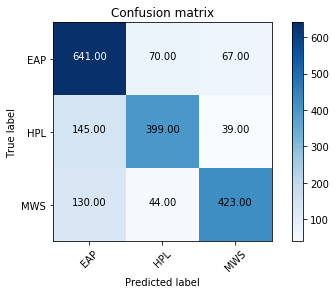

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

preds = format_nn_preds(encoder.classes_, numerical_preds)
conf_mat = confusion_matrix(Y_val, preds)


# NOTE: this function taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = 500
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()

plot_confusion_matrix(conf_mat, classes=encoder.classes_,
                      title="Confusion matrix")
plt.show()

## How does validation accuracy increase with respect to training epochs?

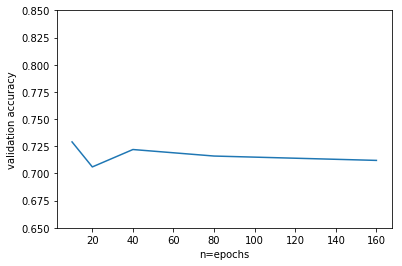

In [49]:
#nn epochs
plt.plot([10, 20, 40, 80, 160], [.729, .706, .722, .716, .712])
plt.xlabel("n=epochs")
plt.ylabel("validation accuracy")
plt.ylim([.65,.85])
plt.show()